In [1]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from make_models import get_MRI_VAE_3D,get_MRI_CVAE_3D
from tqdm import tqdm 

In [2]:
import matplotlib as mpl
from IPython import display
import time
from matplotlib import colors
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn.decomposition import PCA
from rsa_funcs import fit_rsa,make_RDM,get_triu

In [3]:
import tensorflow as tf

In [4]:
data_arr = np.load('../../BC-sim/BC-sim-bigdata/synth-data-01/sim-brain-array-1.npz')
print(list(data_arr.keys()))
data = data_arr['data']
control = data_arr['controls']
patients = data_arr['patients']
n = data.shape[0]
print(data.shape)
data[patients,:,:,:].shape
data[patients].shape

['data', 'controls', 'patients']
(1000, 64, 64, 64)


(500, 64, 64, 64)

In [9]:
# data loader
class cvae_data_loader_adhd():
    ''' this is the info'''
    def __init__(self,data,patients,batch_size=32):
    
        self.data = data
        
        self.n = data.shape[0]
        self.epoch = -1
        self.batch_size = batch_size
        
        self.new_epoch()
        self.n_batches = int(np.floor(min((len(self.adhd_idxs),len(self.td_idxs)))/self.batch_size)) # How many batches fit, take the min(n_ADHD,n_TD) then divide by batch size
        
    def new_epoch(self):

        self.adhd_idxs = np.nonzero(patients==True)[0] # idxs of patients
        self.td_idxs = np.nonzero(patients==False)[0] # idxs of TDs
        
        self.adhd_idxs = np.random.permutation(self.adhd_idxs)
        self.td_idxs = np.random.permutation(self.td_idxs)
        
        self.epoch += 1
        self.b = 0
        
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
        self.batch_adhd_idx = self.adhd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_td_idx = self.td_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        # go through the patients and controls in batch size chunks
        # batch_indeces = all_indices[batch number * batch size : batch number * batch size + batch size]
        
        self.batch_adhd = self.data[self.batch_adhd_idx,:,:,:]
        self.batch_td = self.data[self.batch_td_idx,:,:,:]
        
        _,counts = np.unique(np.hstack((self.batch_adhd_idx,self.batch_td_idx)),return_counts=True)
        assert all(counts==1),'not all unique, somethings wrong'
        
        return self.batch_adhd,self.batch_td

In [10]:
data_loader = cvae_data_loader_adhd(data,patients)

In [6]:
tf.__version__

'2.3.1'

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [11]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

In [25]:
# Make sure you have GPU enabled
# Test 100 epochs
# n_epochs = 100
# n_batches = data_loader.n_batches # dataloader calcs how many batches
# loss = []
# for epoch in tqdm(range(n_epochs)):
#     for batch in range(n_batches):
#         if np.mod(epoch, 10) == 0:
#             cvae.save_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_100_epochs') 
#         adhd_batch, td_batch = data_loader.get_batch()
#         l = cvae.train_on_batch([adhd_batch,td_batch]) # [TG,BG]
#         loss.append(l)
#         if np.mod(epoch, 10) == 0:
#             np.save('sim_loss_100_epochs', np.array(loss))

100%|██████████| 100/100 [15:30<00:00,  9.31s/it]


In [5]:
cvae.load_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_100_epochs')

In [ ]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [12]:
data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

In [ ]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


In [ ]:
recon_patients.shape

In [ ]:
np.array(recon_patients).max()

In [ ]:
np.array(recon_patients).min()

In [ ]:
np.array(data_patients).max()


In [ ]:
np.array(data_patients).min()


## Reconstruction: Subject 0

In [ ]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [9]:
# Make sure you have GPU enabled
# 5000 epochs
# n_epochs = 5000
# n_batches = data_loader.n_batches # dataloader calcs how many batches
# loss = []
# for epoch in tqdm(range(n_epochs)):
#     for batch in range(n_batches):
#         if np.mod(epoch, 10) == 0:
#             cvae.save_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_5k_epochs') 
#         adhd_batch, td_batch = data_loader.get_batch()
#         l = cvae.train_on_batch([adhd_batch,td_batch]) # [TG,BG]
#         loss.append(l)
#         if np.mod(epoch, 10) == 0:
#             np.save('sim_loss_5k_epochs', np.array(loss))

100%|██████████| 5000/5000 [13:10:05<00:00,  9.48s/it]  


In [ ]:
if train_cvae:
    
    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)
    loss = []

In [ ]:
TD_subs = data[controls,:,:,:] # Data of Typically Developing participants 
DX_subs = data[patients,:,:,:] # Data of ADHD participants


nbatches = 50
if train_cvae:
    for i in tqdm(range(1,nbatches)):
        
        DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
        TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
        
        hist = cvae.train_on_batch([DX_batch,TD_batch]);
        loss.append(hist);
        
        mse = ((np.array([DX_batch,TD_batch])-np.array(cvae.predict([DX_batch,TD_batch]))[:,:,:,:,:,0])**2).mean()

        assert not np.isnan(hist),'loss is NaN - somethings wrong'

        im,im1,ss = cvae_query(data, s_encoder, z_encoder, cvae_decoder); 


        if np.mod(i,5)==0: # Plot training progress
            plot_trainProgress(loss,im,im1);
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)

        if np.mod(i,101)==0: # Save every 100 batches
            cvae.save_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_5k_epochs')
            
        if mse < .005:
            break

In [13]:
cvae.load_weights('/mmfs1/data/bergerar/BC-sim/BC-sim-bigdata/synth-data-01/sim_weights_5k_epochs')

In [10]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [14]:
data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

In [12]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


CPU times: user 2min 35s, sys: 14.5 s, total: 2min 49s
Wall time: 2min 50s


In [13]:
recon_patients.shape

TensorShape([500, 64, 64, 64])

In [14]:
np.array(recon_patients).max()

0.9982625

In [15]:
np.array(recon_patients).min()

0.0

In [16]:
np.array(data_patients).max()


1.0

In [17]:
np.array(data_patients).min()


0.0

## Reconstruction: Subject 0

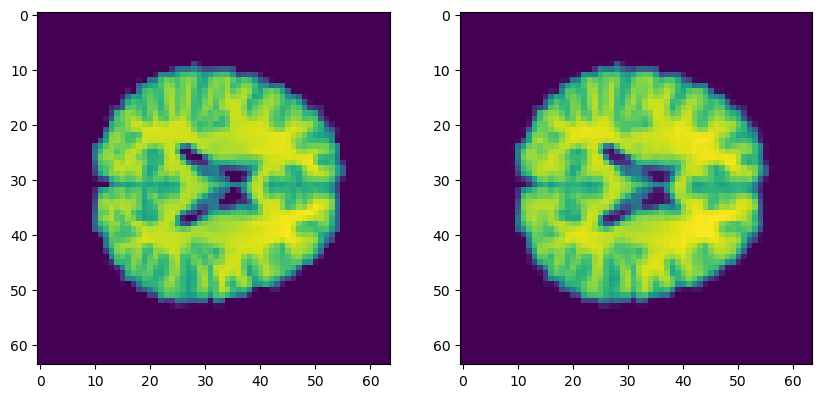

In [18]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [21]:
data = data_patients[0,:,:,:]
predict = recon_patients[0,:,:,:]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(data, predict).numpy()

9.661174e-05

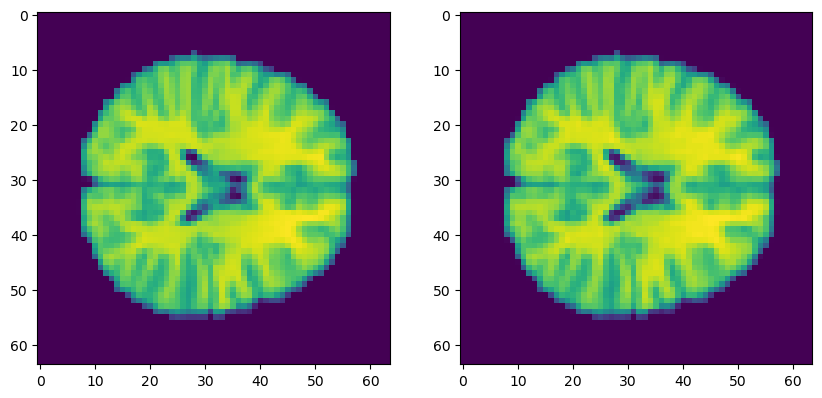

In [22]:
s = 1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

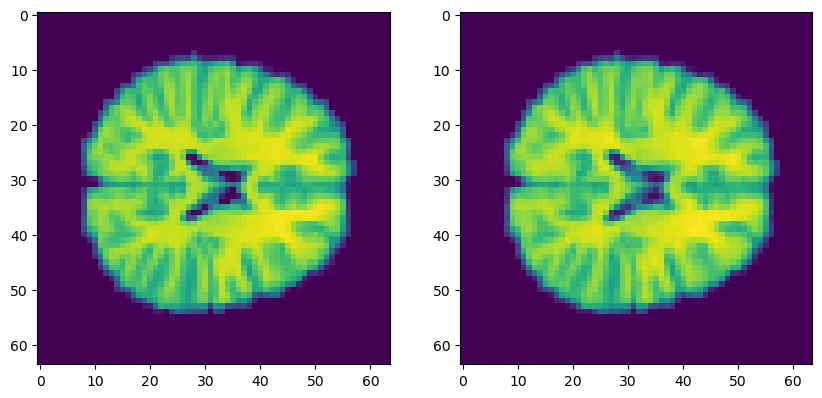

In [23]:
s = 100
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

## MSE loop

In [24]:
mse_list = []
for s in range(0,500):
    data = np.array(data_patients[s,:,:,:])
    predict = np.array(recon_patients[s,:,:,:])
    mse = ((data-predict)**2).mean()
    mse_list.append(mse)

mse_arr = np.array(mse_list)

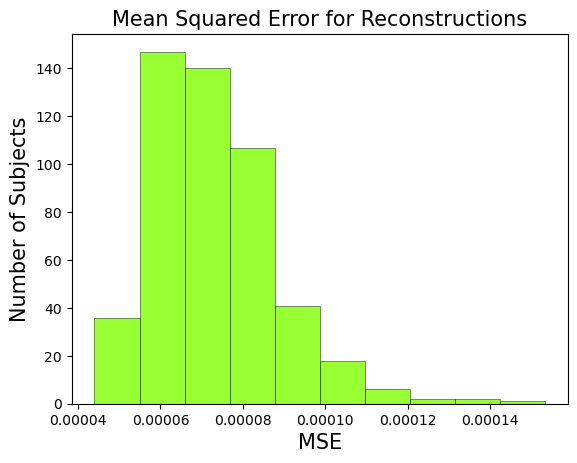

In [25]:
plt.hist(mse_arr, alpha = 0.8, color='chartreuse', edgecolor = 'black', linewidth=0.4 )
plt.title('Mean Squared Error for Reconstructions', fontsize = 15)
plt.xlabel('MSE', fontsize = 15)
plt.ylabel('Number of Subjects', fontsize = 15)
plt.show()

In [26]:
np.argmin(mse_arr) #

435

## Reconstruction with Lowest MSE (Best)

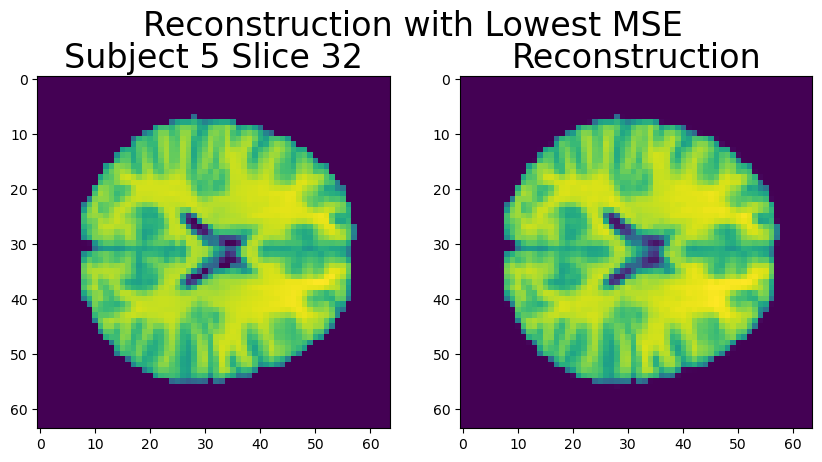

In [27]:
s = 435
figure = plt.figure(figsize=(10,5))
figure.suptitle('Reconstruction with Lowest MSE', fontsize=24)
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.title('Subject 5 Slice 32', fontsize = 24)
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.title('Reconstruction', fontsize = 24)
plt.show()

In [28]:
np.argmax(mse_arr) #

356

## Reconstruction with Highest MSE

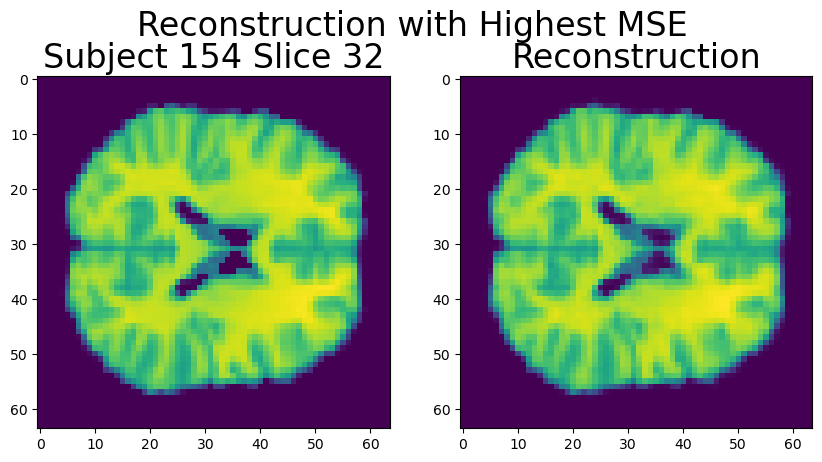

In [30]:
s = 356
figure2 = plt.figure(figsize=(10,5))
figure2.suptitle('Reconstruction with Highest MSE', fontsize=24)
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.title('Subject 154 Slice 32', fontsize = 24)
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.title('Reconstruction', fontsize = 24)
plt.show()

In [15]:
df = pd.read_csv('../../BC-sim/BC-sim-bigdata/synth-data-01/sim_all_def.csv')

In [16]:
ADHDdf = df[df['DX'] != 0]
TDdf = df[df['DX'] == 0]

In [17]:
ADHDdf

,Unnamed: 0,Index,Sub,Sphere 1,Sphere 2,DX,S Deformation,Z Deformation
0,0,0,0,12.834489,10.035014,1,-2.799475,-4.043705
1,1,1,1,11.011581,11.316208,1,0.304627,-3.733940
2,2,2,2,12.606499,14.643771,1,2.037272,-4.385604
3,3,3,3,10.869074,13.482636,1,2.613562,-4.925275
4,4,4,4,6.159082,6.337349,1,0.178267,1.429249
...,...,...,...,...,...,...,...,...
495,495,495,495,7.543617,9.531810,1,1.988193,1.969164
496,496,496,496,12.901628,10.921605,1,-1.980023,-1.618177
497,497,497,497,5.062251,3.099718,1,-1.962533,-4.174104
498,498,498,498,14.173622,13.385439,1,-0.788183,4.945449


In [40]:
symptom_vector = ADHDdf['S Deformation'].values
symptom_vector

array([-2.79947527,  0.30462664,  2.03727205,  2.61356233,  0.17826748,
        0.53419311, -1.84472201,  1.88587619, -1.83464177,  1.35466179,
        1.41844268,  1.1432855 ,  0.51621531,  1.86163145, -0.49363845,
       -1.16619127, -2.94770216,  0.31849785, -0.39681439,  1.93356615,
        2.19137355,  2.47357005,  0.29687882,  1.27066434,  2.2811094 ,
       -1.81082647,  1.85152599, -1.80656489,  1.80041686, -1.144914  ,
        0.69133178, -0.95208009,  0.62800258, -0.6267277 , -1.15082105,
       -2.93080445, -1.34884795, -2.4554004 , -0.63545854,  0.17931633,
       -1.74709229,  0.83689515,  1.61844281, -1.04462509, -1.64994255,
       -1.3633386 , -2.24991411, -0.51175007,  1.30366083, -0.96027256,
        1.03042294, -1.04385548, -1.7209793 , -0.56308292,  2.2846093 ,
        1.49202453,  0.63547176, -0.60979895, -2.63442756, -1.29527528,
        2.86975519, -0.57091531, -1.81801214,  1.51082597,  1.56599708,
        2.76505613,  2.01808388,  2.44681336, -0.26802092, -0.81

In [41]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
symptom = np.array(symptom_vector)

In [24]:
s_patients_rdm = make_RDM(s_patients)
z_patients_rdm = make_RDM(z_patients)
symptom_rdm = make_RDM(symptom)

In [25]:
symptom_rdm.shape

(500, 500)

In [26]:
z_patients_rdm.shape

(500, 500)

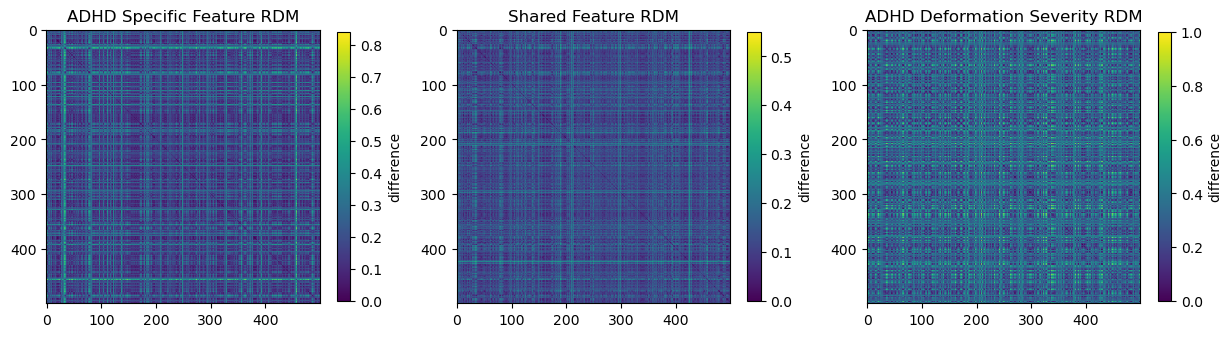

In [27]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm)
plt.title('ADHD Specific Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm)
plt.title('Shared Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,3,3)
plt.imshow(symptom_rdm)
plt.title('ADHD Deformation Severity RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.show()

## RSA: S Deformation

In [28]:
s_symptom_rsa = fit_rsa(s_patients_rdm, symptom_rdm)
s_symptom_rsa

0.028072860600206837

In [29]:
z_symptom_rsa = fit_rsa(z_patients_rdm, symptom_rdm)
z_symptom_rsa

0.025873356795810546

## Randomized RSA base code (shuffle order of array so there's no correlation)

In [12]:
symptom_vector = ADHDdf['S Deformation'].values
symptom_vector

array([-2.79947527,  0.30462664,  2.03727205,  2.61356233,  0.17826748,
        0.53419311, -1.84472201,  1.88587619, -1.83464177,  1.35466179,
        1.41844268,  1.1432855 ,  0.51621531,  1.86163145, -0.49363845,
       -1.16619127, -2.94770216,  0.31849785, -0.39681439,  1.93356615,
        2.19137355,  2.47357005,  0.29687882,  1.27066434,  2.2811094 ,
       -1.81082647,  1.85152599, -1.80656489,  1.80041686, -1.144914  ,
        0.69133178, -0.95208009,  0.62800258, -0.6267277 , -1.15082105,
       -2.93080445, -1.34884795, -2.4554004 , -0.63545854,  0.17931633,
       -1.74709229,  0.83689515,  1.61844281, -1.04462509, -1.64994255,
       -1.3633386 , -2.24991411, -0.51175007,  1.30366083, -0.96027256,
        1.03042294, -1.04385548, -1.7209793 , -0.56308292,  2.2846093 ,
        1.49202453,  0.63547176, -0.60979895, -2.63442756, -1.29527528,
        2.86975519, -0.57091531, -1.81801214,  1.51082597,  1.56599708,
        2.76505613,  2.01808388,  2.44681336, -0.26802092, -0.81

In [13]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
symptom = np.array(symptom_vector)
symptom

array([-2.79947527,  0.30462664,  2.03727205,  2.61356233,  0.17826748,
        0.53419311, -1.84472201,  1.88587619, -1.83464177,  1.35466179,
        1.41844268,  1.1432855 ,  0.51621531,  1.86163145, -0.49363845,
       -1.16619127, -2.94770216,  0.31849785, -0.39681439,  1.93356615,
        2.19137355,  2.47357005,  0.29687882,  1.27066434,  2.2811094 ,
       -1.81082647,  1.85152599, -1.80656489,  1.80041686, -1.144914  ,
        0.69133178, -0.95208009,  0.62800258, -0.6267277 , -1.15082105,
       -2.93080445, -1.34884795, -2.4554004 , -0.63545854,  0.17931633,
       -1.74709229,  0.83689515,  1.61844281, -1.04462509, -1.64994255,
       -1.3633386 , -2.24991411, -0.51175007,  1.30366083, -0.96027256,
        1.03042294, -1.04385548, -1.7209793 , -0.56308292,  2.2846093 ,
        1.49202453,  0.63547176, -0.60979895, -2.63442756, -1.29527528,
        2.86975519, -0.57091531, -1.81801214,  1.51082597,  1.56599708,
        2.76505613,  2.01808388,  2.44681336, -0.26802092, -0.81

In [14]:
from sklearn.utils import shuffle
symptom_random = shuffle(symptom, random_state=0)
print(symptom_random)

[-0.87626267 -0.75057693 -2.65149024  1.8265417  -0.15169728 -1.16619127
 -1.3629379  -0.28038266  0.26032069  0.60016757  2.96344269  1.14249698
 -0.87432573  0.43751536 -2.68937128 -2.48509832 -1.0632886   2.98594829
 -2.2892328  -2.4554004   2.98191501  1.80614132 -0.23039442  1.77747207
 -1.3633386  -0.26737656  2.47357005 -0.31277318  1.50793562 -1.67160645
 -2.21328597 -0.77720205 -2.0800628  -2.14885116  0.41965528 -1.17335156
  1.99454212  0.04860127 -1.87021313 -0.40100873  2.54316723 -2.24991411
 -2.37347571 -0.64739408 -2.06802122  0.30462664  0.94768024  0.63440869
  0.91146763 -2.85274542  2.32422746 -1.27921486 -2.80084451  0.91542812
 -0.64225371  0.51621531  2.16841312 -1.63028774 -0.788634   -0.40296666
 -0.39823789  2.60930984 -0.37114337  2.65012834  0.06619014 -1.85995972
  1.41844268 -0.87817071 -1.40606878 -1.48481773  2.55407719  2.76505613
 -1.54313289  0.39355492  0.84617076  0.46354861  0.07857215  0.74709994
  1.41261325 -0.94648935 -0.88212775 -1.25752862  2

In [15]:
s_patients_rdm = make_RDM(s_patients)
z_patients_rdm = make_RDM(z_patients)
symptom_rdm = make_RDM(symptom_random)

In [16]:
symptom_rdm.shape

(500, 500)

In [17]:
z_patients_rdm.shape

(500, 500)

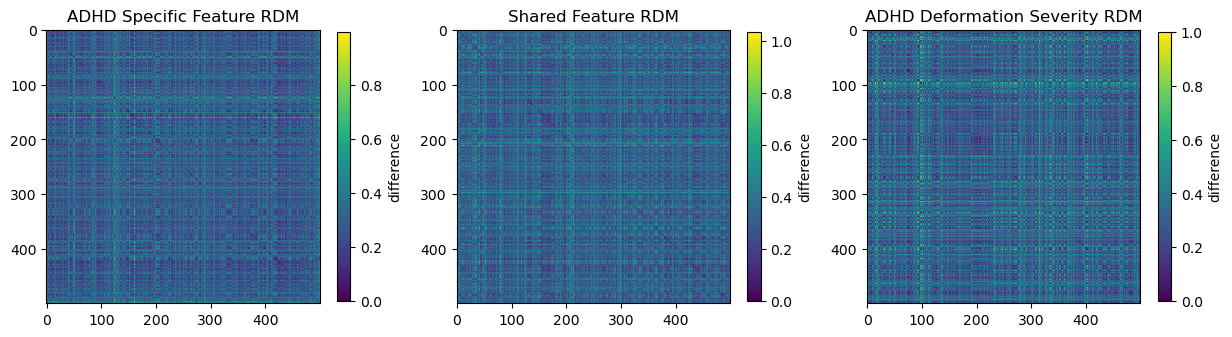

In [18]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm)
plt.title('ADHD Specific Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm)
plt.title('Shared Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,3,3)
plt.imshow(symptom_rdm)
plt.title('ADHD Deformation Severity RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.show()

## RSA: S Deformation

In [19]:
s_symptom_rsa = fit_rsa(s_patients_rdm, symptom_rdm)
s_symptom_rsa

0.003767052222427008

In [20]:
z_symptom_rsa = fit_rsa(z_patients_rdm, symptom_rdm)
z_symptom_rsa

-0.009653863369121414

## Randomized RSA loop

In [18]:
s_rsa = []
z_rsa = []

symptom_vector = ADHDdf['S Deformation'].values
symptom = np.array(symptom_vector)

s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]

s_patients_rdm = make_RDM(s_patients)
z_patients_rdm = make_RDM(z_patients)


from sklearn.utils import shuffle

for s in range(0,1000):
    print(s)

    symptom_random = shuffle(symptom)

    symptom_rdm = make_RDM(symptom_random)

    #symptom_rdm.shape
    #z_patients_rdm.shape

    #plt.figure(figsize = (15,5))
    #plt.subplot(1,3,1)
    #plt.imshow(s_patients_rdm)
    #plt.title('ADHD Specific Feature RDM')
    #plt.colorbar(shrink=0.7, label='difference')
    #plt.subplot(1,3,2)
    #plt.imshow(z_patients_rdm)
    #plt.title('Shared Feature RDM')
    #plt.colorbar(shrink=0.7, label='difference')
    #plt.subplot(1,3,3)
    #plt.imshow(symptom_rdm)
    #plt.title('ADHD Deformation Severity RDM')
    #plt.colorbar(shrink=0.7, label='difference')
    #plt.show()
    
    s_symptom_rsa = fit_rsa(s_patients_rdm, symptom_rdm)
    z_symptom_rsa = fit_rsa(z_patients_rdm, symptom_rdm)
    s_rsa.append(s_symptom_rsa)
    z_rsa.append(z_symptom_rsa)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
s_rsa

[0.0032874232675689868,
 0.007091021718655542,
 0.000720272526854935,
 0.015555572870004869,
 -0.0199132641383707,
 0.020795922042328878,
 0.009172570528785442,
 -0.00899648267625573,
 5.883077889887167e-06,
 -0.00020765229634581178,
 0.02072674434306079,
 0.004249325901205425,
 0.017003568601980764,
 0.020456493764149854,
 -0.019866568806077744,
 -0.0006582309446548139,
 -0.032599611750368386,
 0.009430990951958545,
 0.006469050818953167,
 -0.010722893818380444,
 0.004877844181645232,
 0.022333118837614557,
 -0.002069026400276823,
 -0.01622941049551798,
 -0.01422211760635212,
 -0.010057391172485221,
 -0.016356645614861918,
 -0.01867830158712236,
 -0.0007691127227869557,
 0.0005501668070108405,
 -0.0024509822272684983,
 -0.0065437121775125924,
 -0.0036225321480851404,
 0.02266117929505283,
 0.008846690313048695,
 0.014448013734709898,
 0.003949484718276702,
 0.01032323325037026,
 -0.005758692268809056,
 -0.004537132440886056,
 0.017420878479605672,
 -0.012027270358909086,
 -0.002016079

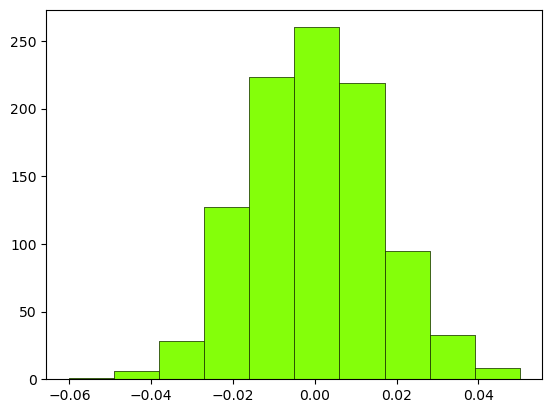

In [21]:
plt.hist(s_rsa, alpha = 0.8, color='chartreuse', edgecolor = 'black', linewidth=0.4 )
plt.show()

In [30]:
count = 0
for i in s_rsa:
    if i > s_symptom_rsa:
        count = count + 1
        


In [31]:
print(count)

41


In [32]:
41/1000

0.041

In [33]:
count2 = 0
for i in z_rsa:
    if i > z_symptom_rsa:
        count2 = count2 + 1
        


In [34]:
print(count2)

40


In [35]:
40/1000

0.04

In [36]:
print(s_symptom_rsa)
print(z_symptom_rsa)

0.028072860600206837
0.025873356795810546


In [ ]:
# clean this up and share on github
# add comments
#remove unnecessary code brain plots etc
#pca
# add in fourth rdm for td def and compare to s and z --> bar plot of four rsa values
#shuffling situation with these rsa values to show that they arent significant

## PCA

In [24]:
data1 = data
data1.shape

(1000, 64, 64, 64)

In [29]:
controls1 = data[control,:,:,:]
controls1.shape

(500, 64, 64, 64)

In [30]:
td_datapca = controls1.reshape(500, -1)
td_datapca.shape

(500, 262144)

In [25]:
patients1 = data[patients,:,:,:]
patients1.shape

(500, 64, 64, 64)

In [32]:
adhd_datapca = patients1.reshape(500, -1)
adhd_datapca.shape
#####

(500, 262144)

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
PCA_patients = pca.fit_transform(adhd_datapca)

In [34]:
print(pca.components_)

[[-1.1546823e-11 -1.7388621e-14 -1.3193120e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.8391067e-07 -2.1600876e-13  3.8083699e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.3312911e-08  1.1663535e-08 -2.1938940e-09 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 ...
 [ 3.3505017e-07 -4.9002671e-07  9.2732826e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 9.2690919e-07 -1.3558788e-07 -2.1053218e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 2.3998709e-06 -1.0854765e-06  6.7834165e-08 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]]


In [35]:
print(sum(pca.explained_variance_ratio_))

0.9620885867625475


In [36]:
lst = np.arange(14)
var_ratio = []
for i in lst:
    pca = PCA(n_components=i)
    pca.fit(adhd_datapca)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

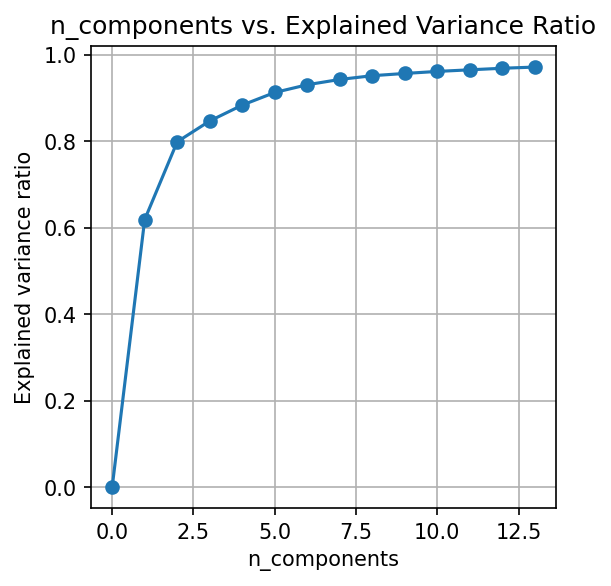

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4),dpi=150)
plt.grid()
plt.plot(lst,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
plt.show()

### PCA RSA

In [ ]:
PCA_patients
symptom = np.array(symptom_vector)

In [44]:
pca_patients_rdm = make_RDM(PCA_patients)
symptom_rdm = make_RDM(symptom)

In [45]:
symptom_rdm.shape

(500, 500)

In [47]:
pca_patients_rdm.shape

(500, 500)

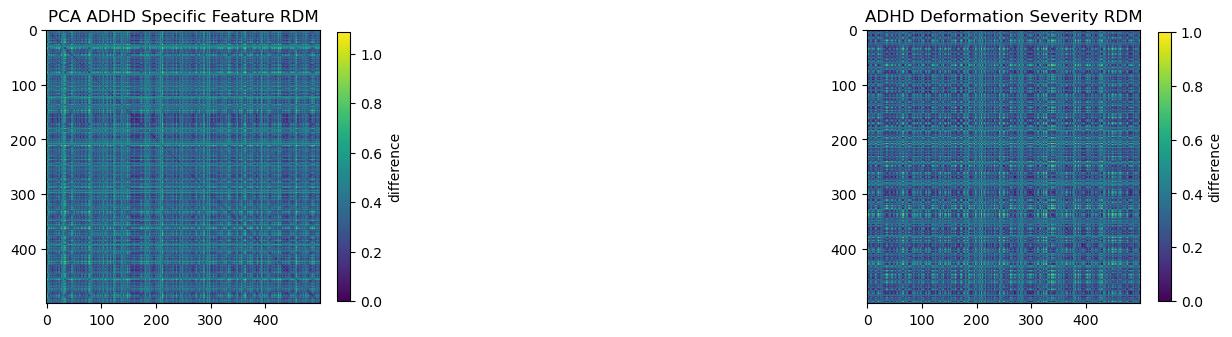

In [54]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(pca_patients_rdm)
plt.title('PCA ADHD Specific Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,3,3)
plt.imshow(symptom_rdm)
plt.title('ADHD Deformation Severity RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.show()

## RSA: S Deformation

In [55]:
pca_symptom_rsa = fit_rsa(pca_patients_rdm, symptom_rdm)
pca_symptom_rsa

0.017815052651695015